# **Header and Contributions**

**Analysis of World Development Indicators**

*Fall 2024 Data Science Project*

Defne Demirekler, Ethan Hartz, David Li, Erica Metheny, Jamie Zhao


Contributions:

A: Project idea **(Ethan)**

B: Dataset Curation and Preprocessing **(Erica, Ethan)**

C: Data Exploration and Summary Statistics **(David, Erica, Ethan, Jamie)**

D: ML Algorithm Design/Development **(David, Ethan, Jamie)**

E: ML Algorithm Training and T est Data Analysis

F: Visualization, Result Analysis, Conclusion

G: Final Tutorial Report Creation **(Erica)**

H: Additional (not listed above)

# **Introduction**

When a country transitions from a developing economy to an emerging economy and eventually to a developed economy, its unique characteristics begin to evolve. For instance, developed countries tend to exhibit higher literacy rates and lower child mortality rates compared to developing countries. Often, these changes are the result of increased population size, increased gross domestic product (GDP, i), and increased access to social services such as education and healthcare. The relationships between these variables are the foundation for development economics and are important to study as they give insight into how a country can increase its quality of life. Our analysis explores the key indicators that shape and reflect a country's development journey.

In addition to social markers of change, our dataset from the World Bank emphasizes a country's agricultural features and its usage of natural resources from 2010 to 2021. By comparing countries from every stage of economic growth, we can begin to understand how properties such as arable land (ii), natural resource rents (iii), and renewable energy usage influence a country's development. With our analysis, we try to answer the following questions:

*   Do developed countries consume more renewable energy than developing countries?
*   Does a country's percentage of arable land influence its GDP?
*   What economy — developing, emerging, or developed — obtains the largest natural resource rents?
*   Can we predict a country's GDP from its consumption of nonrenewable energy?
*   Is it economcially advantageous for a country to be environmentally friendly?

Answering these questions is important as it provides evidence for advocating that countries enforce environmentally conscious policies. Moreover, it helps policy advisors to make informed and effective recommendations. By implementing strong policies, countries build stronger economies and stronger communities.

(i) **gross domestic product**: a measure of the total value of goods and services produced within a country's borders over a specific period of time

(ii) **arable land**: land that can be plowed and used to grow crops or raise livestock

(iii) **natural resource rent**: the economic value of a natural resource that is generated from extracting it, minus the cost of extraction




Imports necessary libraries

In [ ]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import ttest_ind
from scipy.stats import f_oneway
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Imports the World Bank dataset CSV file and fills missing entries

In [ ]:
df = pd.read_csv("worldbank_renew.csv")
df.replace('..', None, inplace=True)

Identifies each Series Name and their associated Series Codes

In [ ]:
series_identifiers = df[['Series Name', 'Series Code']].drop_duplicates()
series_identifiers

,Series Name,Series Code
0,GDP (current US$),NY.GDP.MKTP.CD
1,GDP per capita (current US$),NY.GDP.PCAP.CD
2,Renewable energy consumption (% of total final...,EG.FEC.RNEW.ZS
798,NaN,NaN


Clean the data for GDP vs natural resource rent

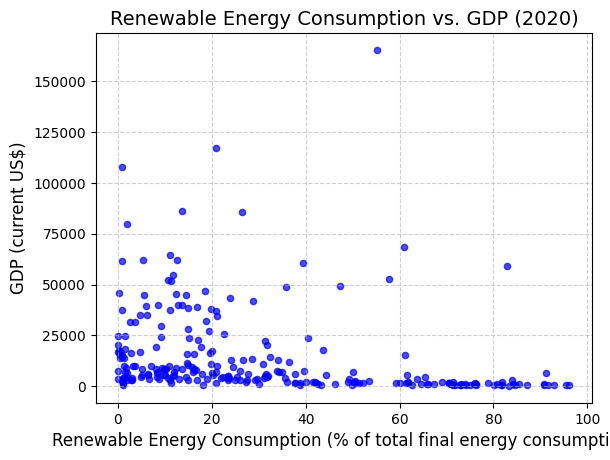

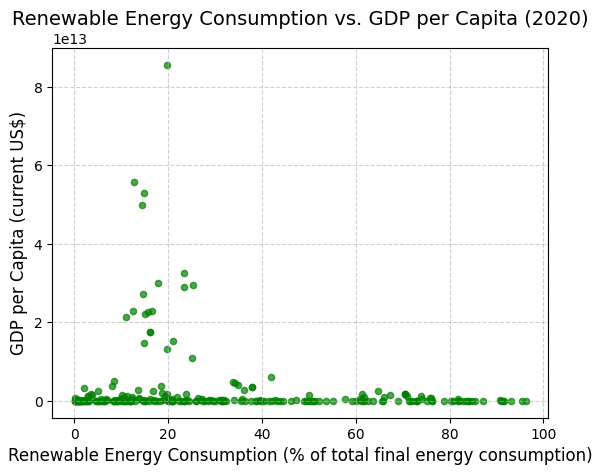

In [ ]:
# resource_code = series_identifiers.loc[series_identifiers['Series Name'] == 'Total natural resources rents (% of GDP)', 'Series Code'].iloc[0]
# gdp_code = series_identifiers.loc[series_identifiers['Series Name'] == 'GDP (current US$)', 'Series Code'].iloc[0]
# gdppc_code = series_identifiers.loc[series_identifiers['Series Name'] == 'GDP per capita (current US$)', 'Series Code'].iloc[0]

# # Filter for relevant Series Codes
# conclusion2_df = df[(df['Series Code'] == resource_code) |
#                     (df['Series Code'] == gdp_code) |
#                     (df['Series Code'] == gdppc_code)]

# # Group by country
# groups = conclusion2_df.groupby('Country Name')

# all_countries_df = pd.DataFrame()

# # Process each country's data
# for country, group in groups:
#     country = groups.get_group(country).transpose()
#     country_cleaned = country.dropna()
#     country_cleaned = country_cleaned.drop(index=['Country Name', 'Country Code', 'Series Name', 'Series Code'])
#     country_cleaned.columns = ['GDPPC', 'Natural Resource Rents % of GDP', 'GDP']

#     # Convert data to numeric
#     country_cleaned['GDPPC'] = pd.to_numeric(country_cleaned['GDPPC'], errors='coerce')
#     country_cleaned['GDP'] = pd.to_numeric(country_cleaned['GDP'], errors='coerce')
#     country_cleaned['Natural Resource Rents % of GDP'] = pd.to_numeric(country_cleaned['Natural Resource Rents % of GDP'], errors='coerce')

#     # Filter for the year 2020 using the correct row label
#     if '2020 [YR2020]' in country_cleaned.index:
#         year_2020_data = country_cleaned.loc[['2020 [YR2020]']]
#         all_countries_df = pd.concat([all_countries_df, year_2020_data], ignore_index=True)

# # Drop rows with zeros
# all_countries_df = all_countries_df[(all_countries_df != 0).all(axis=1)]

# # Reset index
# all_countries_df = all_countries_df.reset_index(drop=True)

# # Plot GDP vs. Natural Resource Rents
# all_countries_df.plot(x='Natural Resource Rents % of GDP', y='GDP', kind='scatter', alpha=0.7, color='blue')
# plt.title('Natural Resource Rents (% of GDP) vs. GDP (2020)', fontsize=14)
# plt.xlabel('Natural Resource Rents (% of GDP)', fontsize=12)
# plt.ylabel('GDP (current US$)', fontsize=12)
# plt.grid(True, linestyle='--', alpha=0.6)
# plt.show()

# # Plot GDPPC vs. Natural Resource Rents
# all_countries_df.plot(x='Natural Resource Rents % of GDP', y='GDPPC', kind='scatter', alpha=0.7, color='green')
# plt.title('Natural Resource Rents (% of GDP) vs. GDP per Capita (2020)', fontsize=14)
# plt.xlabel('Natural Resource Rents (% of GDP)', fontsize=12)
# plt.ylabel('GDP per Capita (current US$)', fontsize=12)
# plt.grid(True, linestyle='--', alpha=0.6)
# plt.show()

renew_code = series_identifiers.loc[series_identifiers['Series Name'] == 'Renewable energy consumption (% of total final energy consumption)', 'Series Code'].iloc[0]
gdp_code = series_identifiers.loc[series_identifiers['Series Name'] == 'GDP (current US$)', 'Series Code'].iloc[0]
gdppc_code = series_identifiers.loc[series_identifiers['Series Name'] == 'GDP per capita (current US$)', 'Series Code'].iloc[0]

# Filter for relevant Series Codes
conclusion3_df = df[(df['Series Code'] == renew_code) |
                    (df['Series Code'] == gdp_code) |
                    (df['Series Code'] == gdppc_code)]

# Group by country
groups = conclusion3_df.groupby('Country Name')

# Combine all entries for Renewable Energy Consumption, GDP, and GDPPC
all_countries_df = pd.DataFrame()
for country_name, group_df in groups:
    country = group_df.transpose()
    country_cleaned = country.dropna()  # Drop rows with NaN values
    country_cleaned = country_cleaned.drop(index=['Country Name', 'Country Code', 'Series Name', 'Series Code'])
    country_cleaned.columns = ['GDPPC', 'GDP', 'Renewable Energy Consumption']

    # Filter for the year 2020 (row labeled as "2020 [YR2020]")
    if '2020 [YR2020]' in country_cleaned.index:
        year_2020_data = country_cleaned.loc[['2020 [YR2020]']]
        # Convert columns to numeric
        year_2020_data['GDPPC'] = pd.to_numeric(year_2020_data['GDPPC'], errors='coerce')
        year_2020_data['GDP'] = pd.to_numeric(year_2020_data['GDP'], errors='coerce')
        year_2020_data['Renewable Energy Consumption'] = pd.to_numeric(year_2020_data['Renewable Energy Consumption'], errors='coerce')

        # Concatenate to the final DataFrame
        all_countries_df = pd.concat([all_countries_df, year_2020_data], ignore_index=True)

# Drop rows with zeros in any column
all_countries_df = all_countries_df[(all_countries_df != 0).all(axis=1)]

# Reset index
all_countries_df = all_countries_df.reset_index(drop=True)

# Plot GDP vs. Renewable Energy Consumption
all_countries_df.plot(x='Renewable Energy Consumption', y='GDP', kind='scatter', alpha=0.7, color='blue')
plt.title('Renewable Energy Consumption vs. GDP (2020)', fontsize=14)
plt.xlabel('Renewable Energy Consumption (% of total final energy consumption)', fontsize=12)
plt.ylabel('GDP (current US$)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# Plot GDPPC vs. Renewable Energy Consumption
all_countries_df.plot(x='Renewable Energy Consumption', y='GDPPC', kind='scatter', alpha=0.7, color='green')
plt.title('Renewable Energy Consumption vs. GDP per Capita (2020)', fontsize=14)
plt.xlabel('Renewable Energy Consumption (% of total final energy consumption)', fontsize=12)
plt.ylabel('GDP per Capita (current US$)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

Plot the data

# **Preprocessing and Setup**

# **Machine learning analysis**

In [ ]:
random_state = 42
np.random.seed(random_state)
test_size = 0.2

def split_data(X, Y, test_size=test_size, random_state=random_state):
    return train_test_split(X, Y, test_size=test_size, random_state=random_state)

# **Visualization**

# **Insights and conclusions**

CONCLUSION